**Блокнот по проведению word-level probing экспериментов**

In [ ]:
!pip --quiet install transformers sentencepiece conllu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 91.1 MB/s eta 0:00:00


In [ ]:
!wget https://raw.githubusercontent.com/UniversalDependencies/UD_French-GSD/master/fr_gsd-ud-test.conllu -O french_gender.conllu

--2023-03-21 17:08:36--  https://raw.githubusercontent.com/UniversalDependencies/UD_French-GSD/master/fr_gsd-ud-test.conllu
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 645402 (630K) [text/plain]
Saving to: ‘french_gender.conllu’

french_gender.conll 100%[===================>] 630.28K  --.-KB/s    in 0.04s   

2023-03-21 17:08:36 (13.8 MB/s) - ‘french_gender.conllu’ saved [645402/645402]



In [ ]:
import torch
import pandas as pd
import numpy as np
from transformers import CamembertModel, CamembertTokenizer, BertModel, BertTokenizer

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

### Loading the model

In [ ]:
# try:
#     del tokenizer
#     del model
# except:
#     pass

def get_pretrained(model_name, model_class=CamembertModel, tokenizer_class=CamembertTokenizer, device=DEVICE):
    tokenizer = tokenizer_class.from_pretrained(model_name)
    model = model_class.from_pretrained(model_name, output_hidden_states=True)
    model = model.to(device)
    return model, tokenizer

model, tokenizer = get_pretrained('camembert-base')

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def get_sentence_embs(sentence, model=model, tokenizer=tokenizer, device=DEVICE):
    """
    Возвращает эмбеддинги предложений по слоям. Эмбеддинг предложения == усреднённые эмбеддинги токенов
    """
    with torch.no_grad():
        inputs = tokenizer(sentence, return_tensors='pt').to(device)
        outputs = model(**inputs)
        return [layer_emb.mean(axis=1).squeeze().cpu().numpy() for layer_emb in outputs.hidden_states][1:]

len(get_sentence_embs('Vous m\'accusez de "subjectivisme".'))  # 12 layers in bert base

12

In [ ]:
class CamembertMergeTokens:
    def __init__(self, calculateEmbeddings=False):
        self.punct = 0
        self.apo = 0
        self.tokens = []
        self.calculateEmbeddings = calculateEmbeddings
        self.embeddings = []

    def finish(self, *args, **kwargs):
        result = (self.tokens, self.embeddings) if self.calculateEmbeddings else self.tokens
        self.__init__(*args, **kwargs)
        return result
    
    def is_punctuation(token):
        token = [x for x in token if x != "▁"]
        return all([x in ".,?!:;()\"" for x in token]) and len(token) != 0
    
    def is_apostrophe(token):
        return token == "\'"
    
    def next_token(self, token, embedding=None):
        if self.calculateEmbeddings and embedding is None:
            print("Missing features in next_token...")

        if CamembertMergeTokens.is_punctuation(token):
            self.punct = 1
        if CamembertMergeTokens.is_apostrophe(token):
            self.apo = 1

        if token.startswith(chr(9601)):
            self.tokens.append(token[1:])
            if self.calculateEmbeddings:
                self.embeddings.append(embedding)
        elif self.punct or self.apo == 2:
            self.tokens.append(token)
            if self.calculateEmbeddings:
                self.embeddings.append(embedding)
        else:
            self.tokens[-1] += token
            if self.calculateEmbeddings:
                self.embeddings[-1] += embedding
        
        if self.punct != 0:
            self.punct = (self.punct + 1) % 3
        if self.apo != 0:
            self.apo = (self.apo + 1) % 3

In [ ]:
def get_word_features(toks, token_features, TokenMerger):
    """
    Принимает в качестве аргументов токенизированное предложение и выход модели на нём. Собирает из выхода по токенам выход по словам.
    """
    token_features = token_features[1:-1] # drop CLS and SEP tokens
    word_features = []
    MergeTokens = TokenMerger(calculateEmbeddings=True)
    for i in range(len(token_features)):
        MergeTokens.next_token(toks[i], token_features[i])
    return torch.stack(MergeTokens.finish()[1], dim=0)


def get_word_embs(sentence, word_inds, layer_inds, TokenMerger, model=model, tokenizer=tokenizer, device=DEVICE):
    """
    Возвращает эмбеддинги слов по слоям. Эмбеддинг слова == усреднённые эмбеддинги токенов, на которые оно разбито (обычно 1 токен).
    """
    with torch.no_grad():
        inputs = tokenizer(sentence, return_tensors='pt').to(device)
        # print(tokenizer.convert_ids_to_tokens(tokenizer(sentence)["input_ids"]))
        outputs = model(**inputs)
        hidden_states = torch.stack(outputs.hidden_states, dim=0)[layer_inds] # Convert tuple of layers to torch tensor
        hidden_states = torch.squeeze(hidden_states, dim=1) # Drop batch dimension which is equal to 1
        # hidden_states = hidden_states[1:] # Drop the input layer

        result = []
        toks = tokenizer.tokenize(sentence)
        for layer in hidden_states:
            result.append(get_word_features(toks, layer, TokenMerger)[word_inds])
        
        return torch.stack(result, dim=0)


text = "J'aime le camembert" #The word camembert is split into multiple tokens => this sentence is good for testing
# text = '''Pour pouvoir mener à bien sa politique dictatoriale, le régime marocain a besoin de stabilité interne pour affronter les "risques externes" engendrés par le conflit du Sahara Occidental.'''
res = get_word_embs(text, [0, 1], [0, 1, 2], CamembertMergeTokens)
res.size()

torch.Size([3, 2, 768])

In [ ]:
def join_parsings(bert_tokenization, ud_tokenization, TokenMerger, verbose=False): # accepts two tokenizations and returns list of features for bert tokenization
    mergeTokens = TokenMerger()
    for item in bert_tokenization:
        mergeTokens.next_token(item)
    bert_words = mergeTokens.finish()

    ud_features = [[]]
    last_word, last_symbol = 0, 0
    skip_ids = -1
    for item in ud_tokenization:
        if type(item["id"]) is int and item["id"] <= skip_ids:
            continue
        if bert_words[last_word][last_symbol:].startswith(item["form"]):
            last_symbol += len(item["form"])
            ud_features[-1].append(item)

            if type(item["id"]) is not int:
                skip_ids = item["id"][2]

            if last_symbol == len(bert_words[last_word]): # We've reached the end in the current word
                if len(ud_features[-1]) == 0:
                    print("this is weird...")
                last_word, last_symbol = last_word + 1, 0 # Switch to the next word in bert tokenization
                ud_features.append([])
        else:
            if verbose:
                print("There has been a problem merging", bert_words, "with", ud_tokenization)
                print(bert_words[:last_word])
            return
    ud_features.pop() # Remove the last emtpy features list
    return bert_words, ud_features

### Loading datasets

In [ ]:
import conllu

In [ ]:
def create_word_by_word_parser(allowed_upos, target_feature, true_value):
    return lambda feats: \
        get_data_from_sentence_word_by_word(feats, \
                                            lambda feat: get_data_from_word(feat, allowed_upos, target_feature, true_value))


def get_data_from_sentence_word_by_word(feats, word_by_word_function):
    word_inds = []
    targets = []
    for ind in range(len(feats)):
        data = word_by_word_function(feats[ind])
        if data is not None:
            word_inds.append(ind)
            targets.append(data)
    return word_inds, targets


def get_data_from_word(feat, allowed_upos, target_feature, true_value):
    if len(feat) > 1: # This is a multiword token, let's skip it for now
        return None
    feat = feat[0]
    if feat["upos"] in allowed_upos and feat["feats"] is not None and feat["feats"].get(target_feature) is not None:
        return int(feat["feats"][target_feature] == true_value)
    return None

In [ ]:
def load_data(dataset_name, TokenMerger, features_extractor, verbose=False):
    with open(dataset_name, 'r') as f:
        dataset = conllu.parse(f.read())

    samples = [[], [], []] # Gather data here, first list contains texts, second contains word indices, third contains labels
    failed, total = 0, 0
    for sentence in dataset:
        total += 1
        bert_tokens = tokenizer.tokenize(sentence.metadata["text"])
        result = join_parsings(bert_tokens, sentence, TokenMerger, verbose=verbose)
        if result is None:
            failed += 1
            continue
        tokens, feats = result
        word_inds, targets = features_extractor(feats)

        if word_inds: # Let's not add sentences with no features to avoid vain embeddings calculation
            samples[0].append(sentence.metadata["text"])
            samples[1].append(word_inds)
            samples[2].append(targets)


    print(failed, "out of", total, "failed")
    data = pd.DataFrame.from_dict({"text": samples[0], "word_ind": samples[1], "target": samples[2]})
    return data

### Learning the probing classifier

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from time import time


# stacked_train_X = np.stack(train_X)
# stacked_val_X = np.stack(val_X)
# stacked_test_X = np.stack(test_X)


def logreg(X_train, y_train, X_test, y_test):
    le = LogisticRegression(tol=0.01, max_iter=1000)
    le = le.fit(X_train, y_train)
    y_pred = le.predict(X_test)
    return f1_score(y_test, y_pred), accuracy_score(y_test, y_pred)


def train(
    layer,
    classifier_func,
    stacked_train_X,
    train_y,
    stacked_test_X,
    test_y
):
    """Обучает пробинг-классификатор (функция classifier_func) для слоя layer"""
    X = stacked_train_X[:, layer, :]
    y = train_y.to_numpy()
    f1, acc = classifier_func(X, y, stacked_test_X[:, layer, :], test_y.to_numpy())
    return f1, acc

In [ ]:
from sklearn.model_selection import train_test_split


def word_level_experiment(layers, TokenMerger, data_extractor):
    print("Loading sentences...")
    french_gender = load_data("french_gender.conllu", TokenMerger, data_extractor)
    all_embs = []
    all_targets = []
    print("Getting embeddings...")
    for row in french_gender.index:
        embs = np.array(get_word_embs(french_gender.loc[row, "text"], french_gender.loc[row, "word_ind"], layers, CamembertMergeTokens).cpu())
        all_embs.append(embs)
        all_targets += french_gender.loc[row, "target"]
    X = np.concatenate(all_embs, axis=1)
    print("Got {} layers, {} entries in the dataset".format(X.shape[0], X.shape[1]))

    print("Training probing classifier")
    res = []
    for layer in range(X.shape[0]):
        X_tr, X_te, y_tr, y_te = train_test_split(X[layer], all_targets, train_size=0.7)
        res.append(logreg(X_tr, y_tr, X_te, y_te))
    
    return res
    

## Эксперименты

In [ ]:
parser = create_word_by_word_parser(["NOUN", "VERB", "ADJ"], "Number", "Sing")
print("Resulting f-measure and accuracy are: {}, {}".format(*(word_level_experiment([0], CamembertMergeTokens, parser))[0]))

Loading sentences...
38 out of 416 failed
Getting embeddings...
Got 1 layers, 2700 entries in the dataset
Training probing classifier
Resulting f-measure and accuracy are: 0.9843621399176954, 0.9765721331689272


Loading sentences...
38 out of 416 failed
Getting embeddings...
Got 13 layers, 2700 entries in the dataset
Training probing classifier
Loading sentences...
38 out of 416 failed
Getting embeddings...
Got 13 layers, 2700 entries in the dataset
Training probing classifier
Loading sentences...
38 out of 416 failed
Getting embeddings...
Got 13 layers, 2700 entries in the dataset
Training probing classifier
Loading sentences...
38 out of 416 failed
Getting embeddings...
Got 13 layers, 2700 entries in the dataset
Training probing classifier
Loading sentences...
38 out of 416 failed
Getting embeddings...
Got 13 layers, 2700 entries in the dataset
Training probing classifier
Loading sentences...
38 out of 416 failed
Getting embeddings...
Got 13 layers, 2700 entries in the dataset
Training probing classifier
Loading sentences...
38 out of 416 failed
Getting embeddings...
Got 13 layers, 2700 entries in the dataset
Training probing classifier
Loading sentences...
38 out of 416 failed
Getting embed

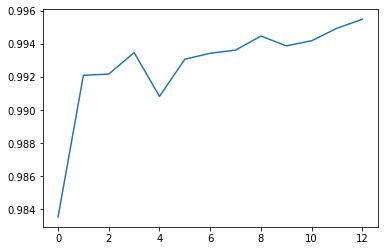

In [ ]:
fmes = np.array([0.0 for x in range(13)])

for x in range(20):
    fmes += np.array([x[0] for x in word_level_experiment(list(range(13)), CamembertMergeTokens, parser)])
fmes /= 20

plt.plot(range(13), fmes)